In [1]:
import requests

def get_wikipedia_views(article: str, year: str):
    base_url = "https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article"
    project = "fr.wikipedia.org"
    access = "all-access"  # (desktop + mobile)
    agent = "user"  # (exclut robots et spiders)
    granularity = "monthly"  # 🔹 Changement ici pour obtenir les vues annuelles

    start_date = f"{year}0101"  # Début de l'année
    end_date = f"{year}1231"  # Fin de l'année
   
    formatted_article = format_article_title(article)
    url = f"{base_url}/{project}/{access}/{agent}/{formatted_article}/{granularity}/{start_date}/{end_date}"
    
    #url = "https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/fr.wikipedia.org/all-access/user/Henri_Hertz/daily/20250201/20250207"
    

    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36"
    }

    response = requests.get(url, headers=headers)
    all_views = 0
    if response.status_code == 200:
        data = response.json()
        for item in data["items"]:
            #all_views += item["timestamp"][:8]: item["views"] for item in data["items"]
            all_views += item["views"]
        
        
    #else:
        #print(f"Erreur {response.status_code}: Impossible de récupérer les données.")

    return all_views


def format_article_title(name: str) -> str:
    return name.replace(" ", "_")

print(get_wikipedia_views("Victor Hugo","2024"))

1027664


In [ ]:
import sys
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd


endpoint_url = "https://query.wikidata.org/sparql"

# Get cities
query = """SELECT DISTINCT ?poet ?name (MIN(?date_birth_raw) AS ?date_birth) (MIN(?date_death_raw) AS ?date_death) 
                (GROUP_CONCAT(DISTINCT ?workLabel; separator=", ") AS ?works) 
                (GROUP_CONCAT(DISTINCT ?movementLabel; separator=", ") AS ?movements)  
WHERE {
  ?poet wdt:P106 wd:Q49757.
  ?poet wdt:P1412 wd:Q150.
  ?poet wdt:P569 ?date_birth_raw.  # Date de naissance obligatoire
  OPTIONAL { ?poet wdt:P570 ?date_death_raw. } # Date de décès optionnelle
  OPTIONAL { 
    ?poet wdt:P800 ?work. 
    ?work rdfs:label ?workLabel.
    FILTER (LANG(?workLabel) = "fr") 
  } # Œuvres principales optionnelles avec leur label en français
  OPTIONAL { 
    ?poet wdt:P135 ?movement. 
    ?movement rdfs:label ?movementLabel.
    FILTER (LANG(?movementLabel) = "fr") 
  } # Mouvements artistiques optionnels avec leur label en français

  ?poet rdfs:label ?name.

  FILTER (LANG(?name) = "fr")
  
  SERVICE wikibase:label { bd:serviceParam wikibase:language "fr". }
}
GROUP BY ?poet ?name

"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (
        sys.version_info[0],
        sys.version_info[1],
    )
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


array = []
results = get_results(endpoint_url, query)

for result in results["results"]["bindings"]:
    name = result["name"]["value"]
    nbr_views = get_wikipedia_views(name, "2024")
    
    # Tester si avec api : https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/fr.wikipedia.org/all-access/user/Henri_Hertz/daily/20250201/20250207
    if nbr_views > 10000:
        print(nbr_views)
        array.append(
            (
                result["poet"]["value"],
                name,
                result["date_birth"]["value"],
                result.get("date_death", {}).get("value", None),  # Vérification clé absente
                result.get("works", {}).get("value", ""),  # Vérification clé absente
                result.get("movements", {}).get("value", ""),
                nbr_views,
            )
        )

dataframe = pd.DataFrame(array, columns=["poet", "name", "date_birth", "date_death", "works", "movements", "popularity"])
dataframe = dataframe.astype(
    dtype={
        "poet": "<U200",       # Chaîne Unicode jusqu'à 200 caractères
        "name": "<U200",       # Nom du poète (chaîne)
        "date_birth": "<U200",  # Date de naissance (datetime)
        "date_death": "<U200",  # Date de décès (datetime, peut contenir NaT)
        "works": "<U1000",     # Liste d'œuvres sous forme de chaîne concaténée
        "movements": "<U500",  # Liste de mouvements littéraires sous forme de chaîne concaténée
        "popularity":"int32",
    }
)

dataframe

In [5]:
# Convertir data frame en Json : 
import json
import pandas as pd

def save_dataframe_to_json(dataframe: pd.DataFrame, filename: str, orient: str = "records", indent: int = 4):
    """
    Convertit un DataFrame pandas en JSON et l'enregistre dans un fichier.

    :param dataframe: Le DataFrame à convertir.
    :param filename: Nom du fichier de sortie (ex: "data.json").
    :param orient: Format du JSON (ex: "records", "split", "index", "columns", "values").
    :param indent: Nombre d'espaces pour l'indentation du JSON.
    """
    json_data = dataframe.to_json(orient=orient, indent=indent, force_ascii=False)
    
    with open(filename, "w", encoding="utf-8") as file:
        file.write(json_data)
#save_dataframe_to_json(dataframe, "data.json")


def json_to_dataframe(json_data):

    # Convertir en DataFrame
    df = pd.read_json(json_data)
    return df
dataframe = json_to_dataframe("data.json")

In [6]:

dataframe_sorted = dataframe.sort_values(by='popularity', ascending=True)
dataframe_sorted

,poet,name,date_birth,date_death,works,movements,popularity
434,http://www.wikidata.org/entity/Q317142,Leonardo Sciascia,1921-01-08T00:00:00Z,1989-11-20T00:00:00Z,Le Contexte,,10034
107,http://www.wikidata.org/entity/Q611066,Germain Nouveau,1851-07-31T00:00:00Z,1920-04-04T00:00:00Z,,symbolisme,10159
25,http://www.wikidata.org/entity/Q123382,Frithjof Schuon,1907-06-18T00:00:00Z,1998-05-05T00:00:00Z,"De l'Unité transcendante des religions, Forme ...","philosophie éternelle, pérennialisme",10163
349,http://www.wikidata.org/entity/Q918268,Maxime Du Camp,1822-02-08T00:00:00Z,1894-02-08T00:00:00Z,,réalisme,10166
256,http://www.wikidata.org/entity/Q1356737,Ernesto Djédjé,1948-01-01T00:00:00Z,1983-06-09T00:00:00Z,,,10184
...,...,...,...,...,...,...,...
105,http://www.wikidata.org/entity/Q687,Molière,1622-01-15T00:00:00Z,1673-02-17T00:00:00Z,"Pastorale comique, Le Médecin volant, Sganarel...",classicisme,814345
287,http://www.wikidata.org/entity/Q708078,Missak Manouchian,1909-09-01T00:00:00Z,1944-02-21T00:00:00Z,,,847834
110,http://www.wikidata.org/entity/Q535,Victor Hugo,1802-02-26T00:00:00Z,1885-05-22T00:00:00Z,"Les Contemplations, Les Orientales, L'Art d'êt...",romantisme français,1027664
172,http://www.wikidata.org/entity/Q2960591,Charles de Gaulle,1837-01-31T00:00:00Z,1880-01-01T00:00:00Z,,,1114902


In [ ]:
nbr = len(dataframe["movements"])
for m in dataframe["movements"]:
    if m == "":
        nbr -= 1
nbr


128

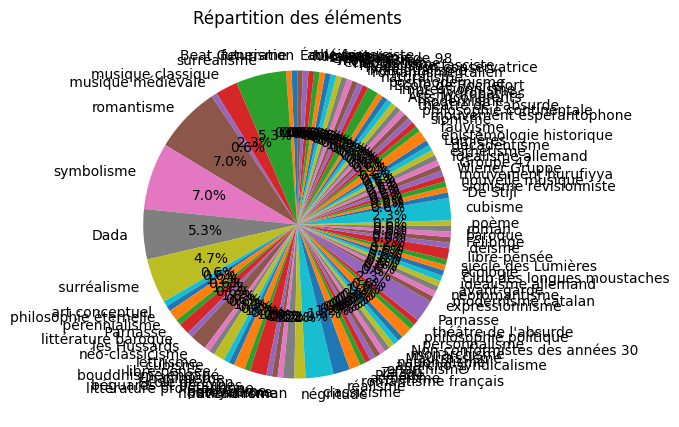

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Utiliser Plotly

def list_to_pie(data):
    # Compter les occurrences des éléments
    counts = Counter(data)
    
    # Extraire les labels et les valeurs
    labels = list(counts.keys())
    sizes = list(counts.values())

    # Créer le pie chart
    plt.figure(figsize=(5, 5))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title("Répartition des éléments")
    plt.show()

# Exemple d'utilisation
data = []
for movement in dataframe["movements"]:
    if movement != "":
        if "," in movement:
            to_add = movement.split(",")
            data += to_add
        else:
            data.append(movement)
list_to_pie(data)


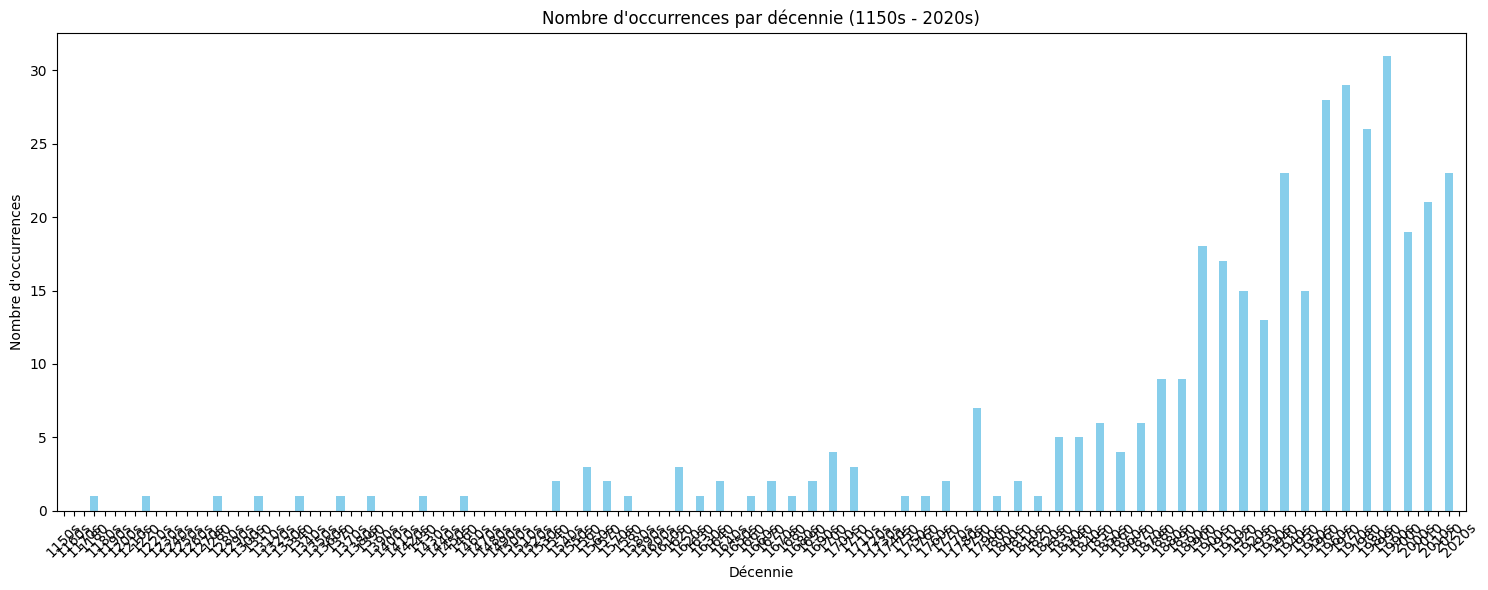

In [27]:
from datetime import datetime

def get_decade(date_str):
    try:
        # Extraire l'année
        year = int(date_str[:4])
        
        # Trouver le début de la décennie
        decade = (year // 10) * 10
        
        return f"{decade}"
    
    except ValueError:
        return None
    
# Appliquer la fonction et supprimer les valeurs None
dataframe["decade"] = dataframe["date_death"].apply(get_decade)

# Compter les occurrences par décennie
decade_counts = dataframe["decade"].dropna().value_counts().sort_index()

# 📌 Ajouter les décennies manquantes de 1150s à 2020s avec 0 occurrence
all_decades = pd.Series(0, index=[f"{year}s" for year in range(1150, 2021, 10)])
decade_counts = all_decades.add(decade_counts, fill_value=0)  # Fusionner avec les vraies données

# 📊 Affichage du graphique
plt.figure(figsize=(15, 6))
decade_counts.plot(kind='bar', color='skyblue', width=0.8)
plt.title('Nombre d\'occurrences par décennie (1150s - 2020s)')
plt.xlabel('Décennie')
plt.ylabel('Nombre d\'occurrences')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# https://fr.wikipedia.org/w/api.php?action=query&format=json&titles=Albert%20Einstein&prop=revisions&rvprop=content&rvsection=0
# lien pour obtenir cadre à droite et première section

In [2]:
%pip install wikipedia-api

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for wikipedia-api: filename=wikipedia_api-0.8.1-py3-none-any.whl size=15505 sha256=6fee58f84d90ea880e084c4212df8ca824e0aa19455a31d2c9e186fdf7eddbb9
  Stored in directory: c:\users\33769\appdata\local\pip\cache\wheels\0b\0f\39\e8214ec038ccd5aeb8c82b957289f2f3ab2251febeae5c2860
Successfully built wikipedia-api
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd

dataframe = pd.read_json("data.json")
dataframe

,poet,name,date_birth,date_death,works,movements,popularity
0,http://www.wikidata.org/entity/Q214642,Paul Auster,1947-02-03T00:00:00Z,2024-04-30T00:00:00Z,"Seul dans le noir, Léviathan, Trilogie new-yor...",,316546
1,http://www.wikidata.org/entity/Q203952,Antoine de Rivarol,1753-06-26T00:00:00Z,1801-04-11T00:00:00Z,De l'universalité de la langue française,,23076
2,http://www.wikidata.org/entity/Q160534,Jack Kerouac,1922-03-12T00:00:00Z,1969-10-21T00:00:00Z,"Les Clochards célestes, Sur la route, Anges de...",Beat Generation,88984
3,http://www.wikidata.org/entity/Q216582,Filippo Tommaso Marinetti,1876-12-22T00:00:00Z,1944-12-02T00:00:00Z,,futurisme,14713
4,http://www.wikidata.org/entity/Q170095,Robert Desnos,1900-07-04T00:00:00Z,1945-06-08T00:00:00Z,,surréalisme,75804
...,...,...,...,...,...,...,...
447,http://www.wikidata.org/entity/Q18222132,Vitalie Rimbaud,1858-06-15T00:00:00Z,1875-12-18T00:00:00Z,,,18478
448,http://www.wikidata.org/entity/Q3367577,Pascal Rambert,1962-07-01T00:00:00Z,None,,,10644
449,http://www.wikidata.org/entity/Q297759,Béatrix Beck,1914-07-30T00:00:00Z,2008-11-30T00:00:00Z,"Léon Morin, prêtre",,12102
450,http://www.wikidata.org/entity/Q472697,Marcel Schwob,1867-08-23T00:00:00Z,1905-02-12T00:00:00Z,"La Tragique Histoire d’Hamlet, Prince de Danemark",symbolisme,10661


### Gestion de si c'est des poetes francais ou non :

In [ ]:
import requests
import json

def askChatGPT(a_envoyer):
    # Création du JSON
    payload = json.dumps({"message": a_envoyer})
    headers = {"Content-Type": "application/json"}

    # Envoi de la requête POST
    response = requests.post(url, data=payload, headers=headers)

    # Vérification de la réponse
    if response.status_code == 200:
        data = response.json()
        return data.get("answer")
    else:
        print("Erreur :", response.status_code, response.text)
        return None

url = "https://internet.com:8000/messages"


column_french_poet = []

nbr_repetition = 10
nbr_poet = 20 # len(dataframe)

nbr_oui = 0
nbr_non = 0
autre = 0
for i in range(nbr_poet):
    reponses = []
    for j in range(nbr_repetition):
        a_envoyer = "Est-ce que 1) " + dataframe["name"][i] +" a parmi ses fonctions principales celle de poète (il ou elle peut être poète uniquement, poète-chanteur, poète-romancier, tant que la poésie détient une place déterminante dans sa production artistique) et si oui, est-ce que 2) cette poésie est principalement rédigée en français ? Si la réponse est oui et oui, réponds simplement oui, mais, à l'inverse, si la réponse est oui et non, ou non et oui, ou non et non, réponds non."
        reponse_ChatGPT = askChatGPT(a_envoyer)
        print(dataframe["name"][i], reponse_ChatGPT)
        if reponse_ChatGPT[:3].lower() == "oui":
            nbr_oui+=1
            reponses.append(True)
        elif reponse_ChatGPT[:3].lower() == "non":
            nbr_non+=1
            reponses.append(False)
        else:
            autre+= 1
    if reponses.count(True) >= len(reponses) / 2:
        column_french_poet.append(True)
    else:
        column_french_poet.append(False)

    #print(askChatGPT("Bonjour"))
print(nbr_oui)
print(nbr_non)
print(autre)
print(column_french_poet)
#dataframe["french_poet?"] = column_french_poet # A DECOMMENTER POUR ENREGISTRER

Paul Auster Non, Paul Auster n'a pas pour fonction principale d'être poète. Sa poésie est principalement rédigée en anglais.
Paul Auster Non.
Paul Auster Non.
Paul Auster Non.
Paul Auster Non.
Paul Auster Non.
Paul Auster Non.
Paul Auster Non.
Paul Auster Non.
Paul Auster Non.
Antoine de Rivarol Oui. Antoine de Rivarol était un poète dont la poésie était principalement rédigée en français.
Antoine de Rivarol Oui. Antoine de Rivarol était principalement poète et sa poésie était principalement rédigée en français.
Antoine de Rivarol Oui. Antoine de Rivarol était un poète et sa poésie était principalement rédigée en français.
Antoine de Rivarol Oui. Antoine de Rivarol était un poète et sa poésie était principalement rédigée en français.
Antoine de Rivarol Oui. Antoine de Rivarol était poète et sa poésie était principalement rédigée en français.
Antoine de Rivarol Oui. Antoine de Rivarol était poète et sa poésie était principalement rédigée en français.
Antoine de Rivarol Non. Antoine de R

In [2]:
import unicodedata

def normalize(text):
    """Supprime les accents et met en minuscule"""
    return unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode().lower()


In [3]:
import wikipediaapi

wiki_wiki = wikipediaapi.Wikipedia(user_agent='PoetNetwork', language='en')

graph = {}

for id_poet in range(20):
    poet_name = dataframe["name"][id_poet]
    page_poet = wiki_wiki.page(poet_name)
    graph[poet_name] = []
    for poet_name_df in dataframe["name"]:
        for poet_name_lk in page_poet.links.keys():
            if normalize(poet_name_df) == normalize(poet_name_lk):
                graph[poet_name].append(poet_name_df)
print(graph)


{'Paul Auster': ['Leonard Cohen', 'Margaret Atwood', 'Jean-Michel Maulpoix', 'Stéphane Mallarmé', 'Shimon Peres'], 'Antoine de Rivarol': ['Arthur de Gobineau', 'Charles Maurras', 'Michel Houellebecq', 'Pierre Boutang', 'Charles de Gaulle', 'François-René de Chateaubriand', 'Julius Evola', 'Léon Bloy'], 'Jack Kerouac': ['James Joyce'], 'Filippo Tommaso Marinetti': ['Robert Desnos', 'Marcel Proust', 'Paul Valéry', 'Marcel Duchamp', 'Paul Déroulède', 'Arthur de Gobineau', 'Tristan Tzara', 'Francis Picabia', 'Blaise Cendrars', 'Samuel Beckett', 'Antonin Artaud', 'Paul Éluard', 'Alfred Jarry', 'James Joyce', 'Marc Chagall', 'Max Ernst', 'Robert Brasillach', 'Maurice Maeterlinck', 'Ernest Hemingway', 'Max Jacob', 'Jean Arp', 'Rainer Maria Rilke', 'Guillaume Apollinaire', 'Jean Cocteau', 'Karel Čapek', 'Edgar Degas', 'Émile Zola', 'Julius Evola', 'Stéphane Mallarmé', 'August Strindberg', 'André Breton'], 'Robert Desnos': ['Marcel Duchamp', 'Tristan Tzara', 'Michel Leiris', 'Louis Aragon', 'Fr

In [5]:
%pip install networkx pyvis


   ---------------------------------------- 0.0/756.0 kB ? eta -:--:--
   - ------------------------------------- 30.7/756.0 kB 660.6 kB/s eta 0:00:02
   ------------ --------------------------- 235.5/756.0 kB 2.9 MB/s eta 0:00:01
   ---------------------------------------  747.5/756.0 kB 5.9 MB/s eta 0:00:01
   ---------------------------------------- 756.0/756.0 kB 6.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/134.9 kB ? eta -:--:--
   ---------------------------------------- 134.9/134.9 kB ? eta 0:00:00
   ---------------------------------------- 0.0/46.3 kB ? eta -:--:--
   ---------------------------------------- 46.3/46.3 kB ? eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


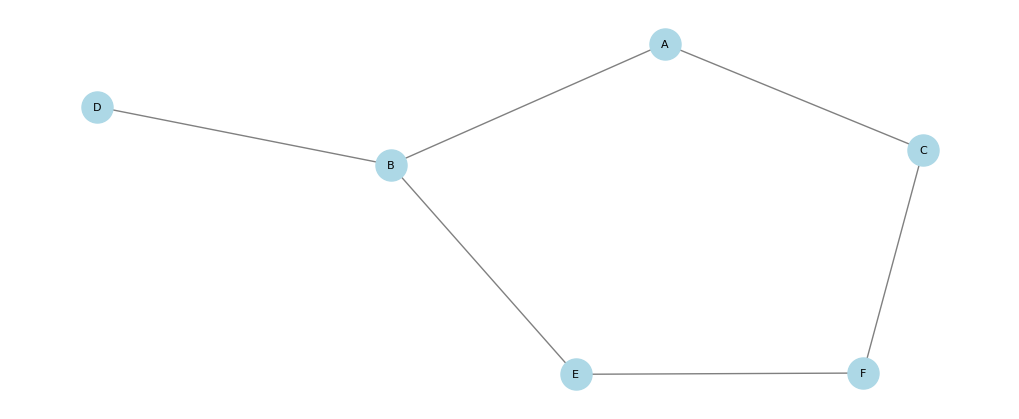

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network


graph = {
    'A': ['B', 'C'],
    'B': ['A', 'D', 'E'],
    'C': ['A', 'F'],
    'D': ['B'],
    'E': ['B', 'F'],
    'F': ['C', 'E']
}

G = nx.Graph()

for node, neighbors in graph.items():
    for neighbor in neighbors:
        G.add_edge(node, neighbor)

# Dessin du graphe
plt.figure(figsize=(10, 4))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=8)




plt.show()

In [4]:
import csv
import pandas as pd



def graph_to_links(graph):
    links = []
    seen_edges = set()

    for node, neighbors in graph.items():
        for neighbor in neighbors:
            edge = tuple(sorted([node, neighbor]))  # Trie pour éviter les doublons
            if edge not in seen_edges:
                seen_edges.add(edge)
                links.append(list(edge))

    return links

def save_links_to_csv(links, filename="links.csv"):
    with open(filename, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["src", "dest"])  # En-tête du fichier CSV
        writer.writerows(links)
"""
graph = {
    'A': ['B', 'C'],
    'B': ['A', 'D', 'E'],
    'C': ['A', 'F'],
    'D': ['B'],
    'E': ['B', 'F'],
    'F': ['C', 'E']
}
"""


links = graph_to_links(graph)
save_links_to_csv(links)